In [18]:
import torch 
from dataloader import ECG_Data, prepare_dataset
from resnet_1d import SERes1d
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [19]:
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda")  # Set device to GPU
else:
    print("CUDA is not available. Training on CPU.")
    device = torch.device("cpu")  # Set device to CPU

CUDA is available!


In [67]:
def training_loop(model:torch.nn.Module,
                  optimizer,
                  criterion,
                  train_loader:torch.utils.data.DataLoader,
                  validation_loader:torch.utils.data.DataLoader,
                  epochs:int = 100,
                  )-> tuple :
    
    train_losses = np.array([])
    train_accuracies = np.array([])
    val_losses = np.array([])
    val_accuracies = np.array([])
    for epoch in range(epochs):
        running_loss = 0.0
        train_acc = 0.0
        model.train()
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = criterion(out, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_acc += torch.sum(torch.sigmoid(out).argmax(dim=1) == label)
            running_loss += loss.item()*data.size(0)
        train_accuracies = np.append(train_accuracies,train_acc.cpu()/len(train_loader.dataset))
        train_losses = np.append(train_losses, running_loss/len(train_loader.dataset))
        print(f'Epoch:{epoch}\n-----------Training------------- \n Loss:{train_losses[epoch]}, accuracy:{train_accuracies[epoch]}')

        model.eval()
        val_acc = 0.0
        val_running_loss = 0.0
        for data,label in validation_loader:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = criterion(out, label)
            val_acc += torch.sum(torch.sigmoid(out).argmax(dim=1) == label)
            val_running_loss += loss.item()*data.size(0)
        val_accuracies = np.append(val_accuracies,val_acc.cpu()/len(validation_loader.dataset))
        val_losses = np.append(val_losses, val_running_loss/len(validation_loader.dataset))
        print(f'--------------Validation -------- \n  Loss:{val_losses[epoch]}, accuracy:{val_accuracies[epoch]}')

    return (val_accuracies,val_losses),(train_accuracies,train_losses)

In [68]:
final_data=prepare_dataset(r"sample_dataset/ptbxl_database.csv")


    #split zrobiłem sklearnem bo po co się męczyć
ECG_train,ECG_test=train_test_split(final_data,test_size=0.2,random_state=42)

    #inaczej nie działa xd
ECG_train=ECG_train.reset_index()
ECG_test=ECG_test.reset_index()
    #tu ważne żeby podać ścieżkę do folderu z danymi, ale tylko folderu, bo potem to już się samo sklei
train_dataset=ECG_Data(ECG_train, r"/home/wicia/Documents/Horzyk/resnet_project/sample_dataset/")
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=2)
test_dataset=ECG_Data(ECG_test, r"/home/wicia/Documents/Horzyk/resnet_project/sample_dataset/")
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=2)

In [69]:
number_of_channels=12
number_of_classes=6
model = SERes1d(number_of_channels,number_of_classes).to(device)

In [70]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
number_of_epochs = 50

In [71]:
val_history,train_history = training_loop(model,optimizer,criterion,train_loader,test_loader,number_of_epochs)

Epoch:0
-----------Training------------- 
 Loss:2.1401904713023794, accuracy:0.09090909361839294
--------------Validation -------- 
  Loss:2.3186635971069336, accuracy:0.0
Epoch:1
-----------Training------------- 
 Loss:1.9229260141199285, accuracy:0.09090909361839294
--------------Validation -------- 
  Loss:8.490762431174517, accuracy:0.3333333432674408
Epoch:2
-----------Training------------- 
 Loss:0.5899339751763777, accuracy:0.9090909361839294
--------------Validation -------- 
  Loss:7.889367539270704, accuracy:0.3333333432674408
Epoch:3
-----------Training------------- 
 Loss:0.22717612169005655, accuracy:1.0
--------------Validation -------- 
  Loss:7.083113958981509, accuracy:0.3333333432674408
Epoch:4
-----------Training------------- 
 Loss:0.10785621472380379, accuracy:1.0
--------------Validation -------- 
  Loss:6.574053187233706, accuracy:0.3333333432674408
Epoch:5
-----------Training------------- 
 Loss:0.061743460256945, accuracy:1.0
--------------Validation -------- 


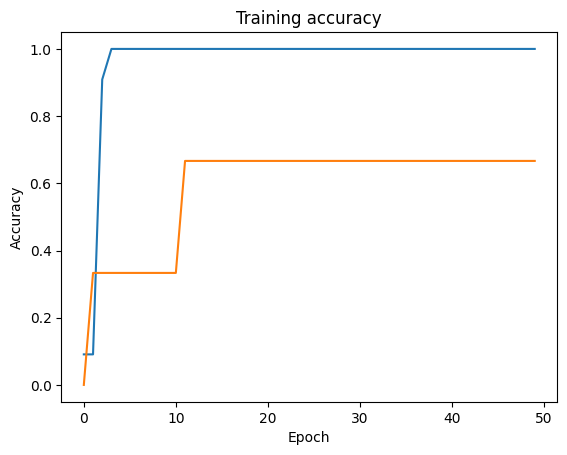

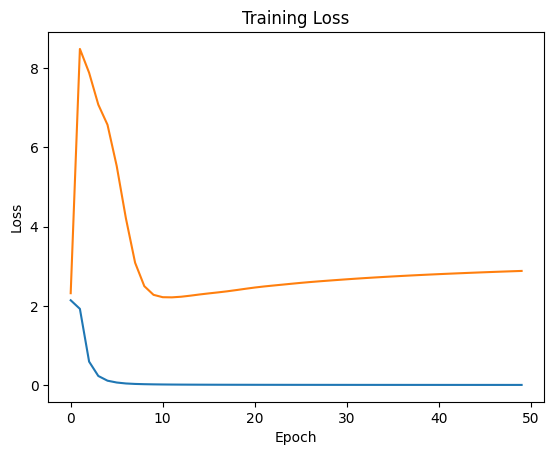

In [72]:
plt.plot(train_history[0])
plt.plot(val_history[0])
plt.title("Training accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()
plt.plot(train_history[1])
plt.plot(val_history[1])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [40]:
model.eval()
accuracy = 0
for data,label in test_loader :
    data = data.to(device)
    out = model(data)
    accuracy += torch.sum(torch.sigmoid(out).argmax(dim=1) == label.to(device))

accuracy = accuracy/ len(test_loader.dataset)
print(accuracy)

tensor(0.3333, device='cuda:0')
